In [1]:
# 📦 Imports y Configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import time

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


---

## 2. ¿Qué son los Hiperparámetros?

### Parámetros vs Hiperparámetros

| Concepto | Definición | Ejemplo | ¿Quién lo ajusta? |
|----------|------------|---------|-------------------|
| **Parámetros** | Valores que el modelo **aprende** de los datos | Coeficientes de regresión, pesos de redes | El algoritmo (`.fit()`) |
| **Hiperparámetros** | Valores que **tú defines** antes de entrenar | `max_depth`, `learning_rate`, `n_estimators` | Tú (el Data Scientist) |

### Analogía: El Chef y la Receta

```
🍕 PARÁMETROS (El chef decide mientras cocina):
   - Cuánta sal exacta poner después de probar
   - El punto exacto de cocción de la carne

🔧 HIPERPARÁMETROS (Tú decides ANTES de empezar):
   - Temperatura del horno (¿180°C o 200°C?)
   - Tiempo de cocción (¿30 min o 45 min?)
   - Tamaño de los trozos (¿pequeños o grandes?)
```

In [2]:
# Ejemplo: Hiperparámetros comunes de LightGBM
hiperparametros = pd.DataFrame({
    'Hiperparámetro': ['n_estimators', 'learning_rate', 'max_depth', 'num_leaves',
                       'min_child_samples', 'subsample', 'colsample_bytree'],
    'Significado': ['Número de árboles', 'Velocidad de aprendizaje', 'Profundidad máxima',
                    'Hojas por árbol', 'Mínimo por hoja', 'Muestreo de filas', 'Muestreo de columnas'],
    'Rango Típico': ['100-1000', '0.01-0.3', '3-12', '20-300', '5-100', '0.5-1.0', '0.5-1.0'],
    'Efecto si ↑': ['Más potencia (y tiempo)', 'Más rápido pero inestable',
                    'Más complejo (overfit)', 'Más complejo', 'Más conservador',
                    'Más aleatoriedad', 'Más aleatoriedad']
})

print("📊 Hiperparámetros Clave de LightGBM")
print("=" * 80)
display(hiperparametros)


📊 Hiperparámetros Clave de LightGBM


,Hiperparámetro,Significado,Rango Típico,Efecto si ↑
0,n_estimators,Número de árboles,100-1000,Más potencia (y tiempo)
1,learning_rate,Velocidad de aprendizaje,0.01-0.3,Más rápido pero inestable
2,max_depth,Profundidad máxima,3-12,Más complejo (overfit)
3,num_leaves,Hojas por árbol,20-300,Más complejo
4,min_child_samples,Mínimo por hoja,5-100,Más conservador
5,subsample,Muestreo de filas,0.5-1.0,Más aleatoriedad
6,colsample_bytree,Muestreo de columnas,0.5-1.0,Más aleatoriedad


---

## 3. El Problema: Búsqueda en un Espacio Infinito

### ¿Cuántas Combinaciones Existen?

Supongamos que queremos probar solo **5 valores** para cada uno de **7 hiperparámetros**:

$$\text{Combinaciones} = 5^7 = 78,125$$

Si cada entrenamiento toma **1 minuto**:

$$\text{Tiempo Total} = \frac{78,125 \text{ minutos}}{60 \times 24} \approx 54 \text{ días}$$

**¡Más de un mes y medio para probar todo!** 😱

C:\Users\Theki\AppData\Local\Temp\ipykernel_34264\1441618609.py:24: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


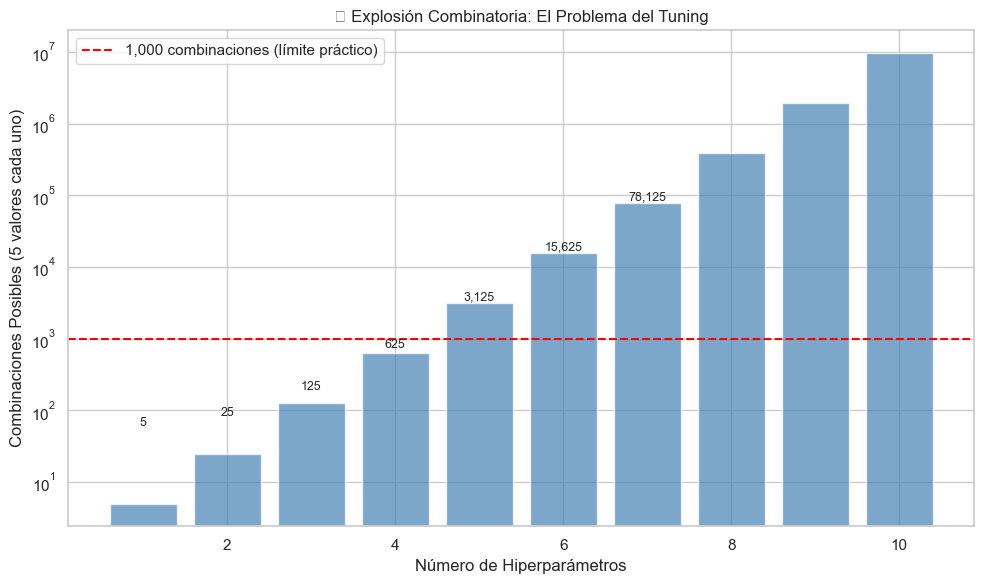

📉 GridSearch se vuelve impracticable rápidamente.
   Necesitamos estrategias más inteligentes.


In [3]:
# Visualización del problema de escala
n_params = np.arange(1, 11)
valores_por_param = 5
combinaciones = valores_por_param ** n_params

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(n_params, combinaciones, color='steelblue', alpha=0.7)

# Marcar el punto crítico
ax.axhline(y=1000, color='red', linestyle='--',
           label='1,000 combinaciones (límite práctico)')

# Añadir etiquetas
for bar, comb in zip(bars, combinaciones):
    if comb < 100000:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{comb:,.0f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Número de Hiperparámetros')
ax.set_ylabel('Combinaciones Posibles (5 valores cada uno)')
ax.set_title('💥 Explosión Combinatoria: El Problema del Tuning')
ax.set_yscale('log')
ax.legend()
plt.tight_layout()
plt.show()

print("📉 GridSearch se vuelve impracticable rápidamente.")
print("   Necesitamos estrategias más inteligentes.")


---

## 4. GridSearch: El Método Prehistórico

### ¿Cómo Funciona?

GridSearch **prueba TODAS las combinaciones** de valores que le das.

```python
param_grid = {
    'max_depth': [3, 5, 7, 9],      # 4 valores
    'learning_rate': [0.01, 0.1, 0.3]  # 3 valores
}
# Total: 4 × 3 = 12 entrenamientos
```

### Analogía: El Buscador de Tesoros Metódico

```
🗺️ Imagina una isla donde hay un tesoro enterrado.

GridSearch: "Voy a cavar un hoyo cada 10 metros en toda la isla.
            No me importa si hay pistas. Sistemático hasta el final."

Resultado: Encuentra el tesoro... después de 10,000 hoyos.
```

C:\Users\Theki\AppData\Local\Temp\ipykernel_34264\1622669440.py:39: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


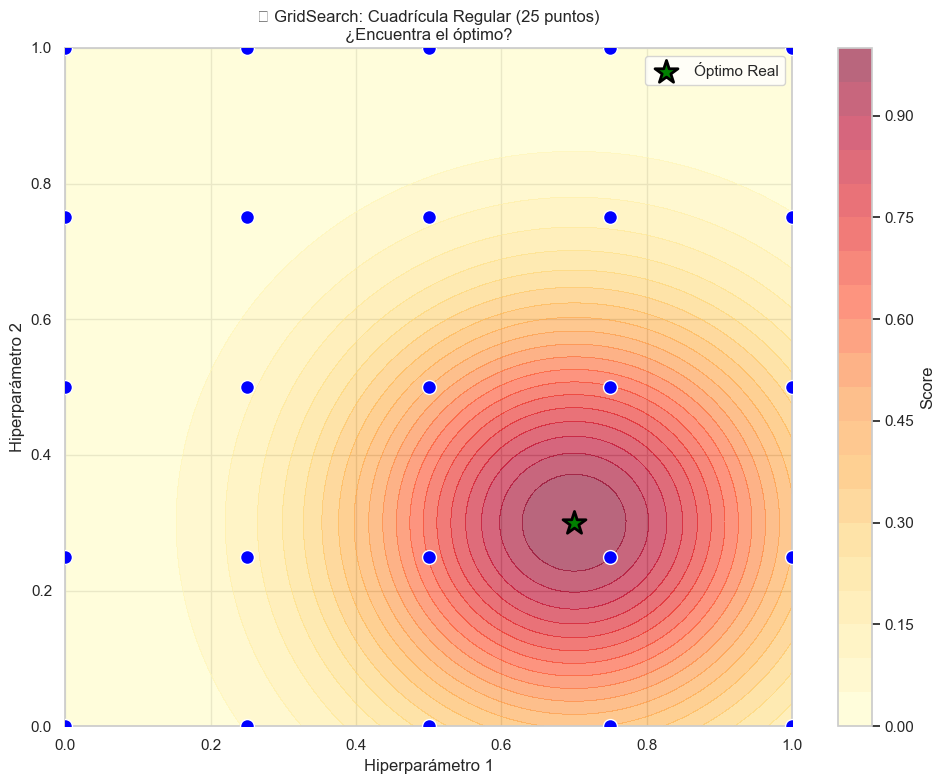

📊 GridSearch probó 25 combinaciones
📊 Mejor valor encontrado: 0.931
⚠️ ¡Ningún punto cayó cerca del óptimo real!


In [4]:
# Simulación visual de GridSearch
def funcion_objetivo(x, y):
    """Función con un máximo claro para visualización"""
    return np.exp(-((x-0.7)**2 + (y-0.3)**2) / 0.1) + np.random.normal(0, 0.02)


# Crear superficie real
x_range = np.linspace(0, 1, 100)
y_range = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = np.exp(-((X-0.7)**2 + (Y-0.3)**2) / 0.1)

# GridSearch: puntos en cuadrícula regular
grid_x = np.linspace(0, 1, 5)
grid_y = np.linspace(0, 1, 5)
grid_points = [(x, y) for x in grid_x for y in grid_y]
grid_values = [funcion_objetivo(x, y) for x, y in grid_points]

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))

# Superficie de fondo
contour = ax.contourf(X, Y, Z, levels=20, cmap='YlOrRd', alpha=0.6)
plt.colorbar(contour, label='Score')

# Puntos de GridSearch
for (x, y), val in zip(grid_points, grid_values):
    ax.scatter(x, y, c='blue', s=100, edgecolors='white', zorder=5)

# Marcar el óptimo real
ax.scatter(0.7, 0.3, c='green', s=300, marker='*', edgecolors='black',
           linewidth=2, zorder=10, label='Óptimo Real')

ax.set_xlabel('Hiperparámetro 1')
ax.set_ylabel('Hiperparámetro 2')
ax.set_title(
    '📐 GridSearch: Cuadrícula Regular (25 puntos)\n¿Encuentra el óptimo?')
ax.legend()
plt.tight_layout()
plt.show()

print(f"📊 GridSearch probó {len(grid_points)} combinaciones")
print(f"📊 Mejor valor encontrado: {max(grid_values):.3f}")
print(f"⚠️ ¡Ningún punto cayó cerca del óptimo real!")


> **⚠️ Real-World Warning: GridSearch en Producción**
> GridSearch solo funciona bien cuando:
> - Tienes **pocos** hiperparámetros (2-3)
> - Tienes **mucho** tiempo/recursos de cómputo
> - No te importa desperdiciar evaluaciones en zonas malas
> 
> En la vida real, es casi siempre una mala elección.

---

## 5. RandomSearch: El Hermano Listo

### ¿Cómo Funciona?

RandomSearch **elige combinaciones al azar** del espacio de búsqueda.

### ¿Por Qué es Mejor?

| Aspecto | GridSearch | RandomSearch |
|---------|------------|---------------|
| Cobertura | Solo puntos de la cuadrícula | Explora todo el espacio |
| Escalabilidad | Exponencial | Lineal (tú eliges cuántos) |
| Sensibilidad | Puede fallar el óptimo | Más probabilidades de acercarse |

### La Intuición Clave

```
🎯 Si solo 1 hiperparámetro importa realmente:

GridSearch (5×5 = 25 puntos): Prueba solo 5 valores de ese HP.
RandomSearch (25 puntos):     Prueba 25 valores diferentes de ese HP.

→ RandomSearch tiene 5x más chances de encontrar el óptimo.
```

C:\Users\Theki\AppData\Local\Temp\ipykernel_34264\958022376.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


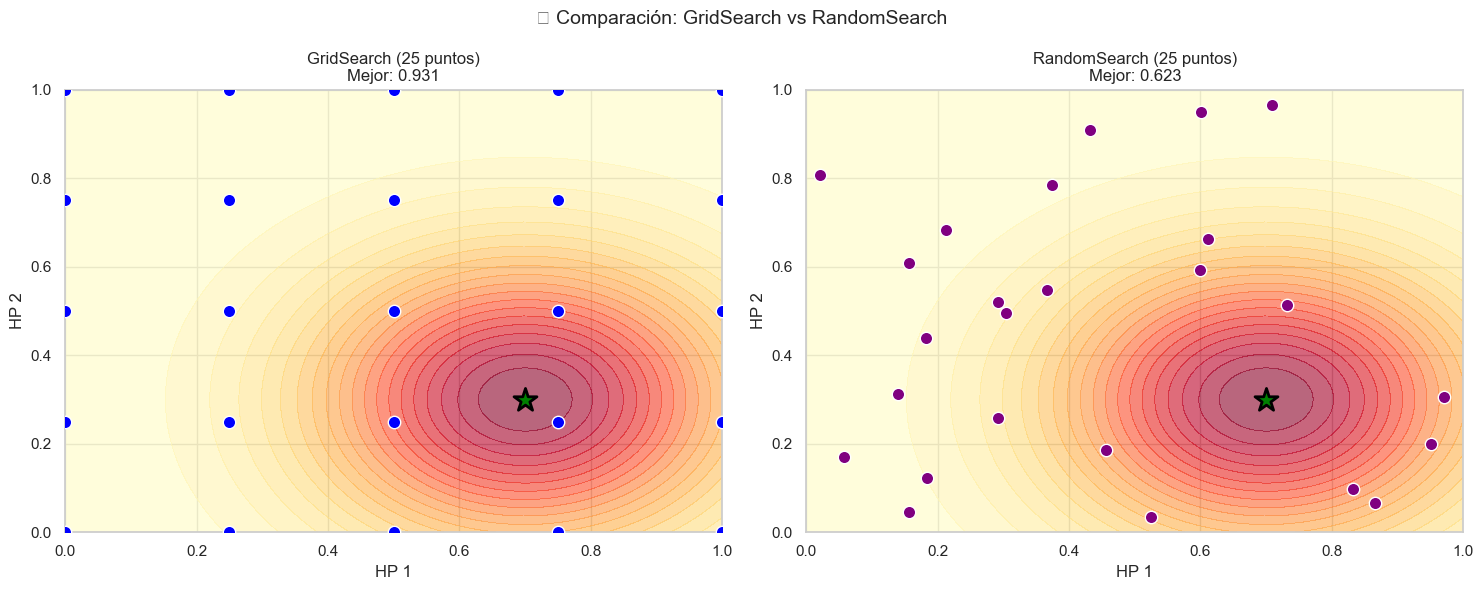

🔵 GridSearch mejor valor: 0.931
🟣 RandomSearch mejor valor: 0.623

💡 RandomSearch cubre mejor el espacio con la misma cantidad de puntos.


In [5]:
# RandomSearch: puntos aleatorios
np.random.seed(42)
n_random = 25
random_x = np.random.uniform(0, 1, n_random)
random_y = np.random.uniform(0, 1, n_random)
random_points = list(zip(random_x, random_y))
random_values = [funcion_objetivo(x, y) for x, y in random_points]

# Comparación visual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# GridSearch
ax = axes[0]
ax.contourf(X, Y, Z, levels=20, cmap='YlOrRd', alpha=0.6)
for (x, y) in grid_points:
    ax.scatter(x, y, c='blue', s=80, edgecolors='white', zorder=5)
ax.scatter(0.7, 0.3, c='green', s=300, marker='*',
           edgecolors='black', linewidth=2, zorder=10)
ax.set_title(f'GridSearch (25 puntos)\nMejor: {max(grid_values):.3f}')
ax.set_xlabel('HP 1')
ax.set_ylabel('HP 2')

# RandomSearch
ax = axes[1]
ax.contourf(X, Y, Z, levels=20, cmap='YlOrRd', alpha=0.6)
for (x, y) in random_points:
    ax.scatter(x, y, c='purple', s=80, edgecolors='white', zorder=5)
ax.scatter(0.7, 0.3, c='green', s=300, marker='*',
           edgecolors='black', linewidth=2, zorder=10)
ax.set_title(f'RandomSearch (25 puntos)\nMejor: {max(random_values):.3f}')
ax.set_xlabel('HP 1')
ax.set_ylabel('HP 2')

plt.suptitle('📊 Comparación: GridSearch vs RandomSearch', fontsize=14)
plt.tight_layout()
plt.show()

print(f"🔵 GridSearch mejor valor: {max(grid_values):.3f}")
print(f"🟣 RandomSearch mejor valor: {max(random_values):.3f}")
print(f"\n💡 RandomSearch cubre mejor el espacio con la misma cantidad de puntos.")


---

## 6. Búsqueda Bayesiana: El Detective

### La Gran Idea

En lugar de buscar a ciegas, la búsqueda Bayesiana **aprende del pasado**:

1. **Evalúa** algunos puntos iniciales
2. **Construye un modelo** de cómo se comporta la función objetivo
3. **Predice** dónde es más probable encontrar el óptimo
4. **Explora** esa zona prometedora
5. **Repite** con mejor información

### Analogía: El Detective con Detector de Metales

```
🕵️ Búsqueda Bayesiana:

1. "Hago 3 excavaciones aleatorias para tener pistas."
2. "El detector pita más fuerte hacia el norte. Interesante."
3. "Mi siguiente excavación será al norte, pero no exactamente donde pité.
    Podría haber algo mejor un poco más allá."
4. "¡Bip bip bip! Encontré oro a los 10 intentos."
```

C:\Users\Theki\AppData\Local\Temp\ipykernel_34264\3553192911.py:60: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Theki\AppData\Local\Temp\ipykernel_34264\3553192911.py:60: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packa

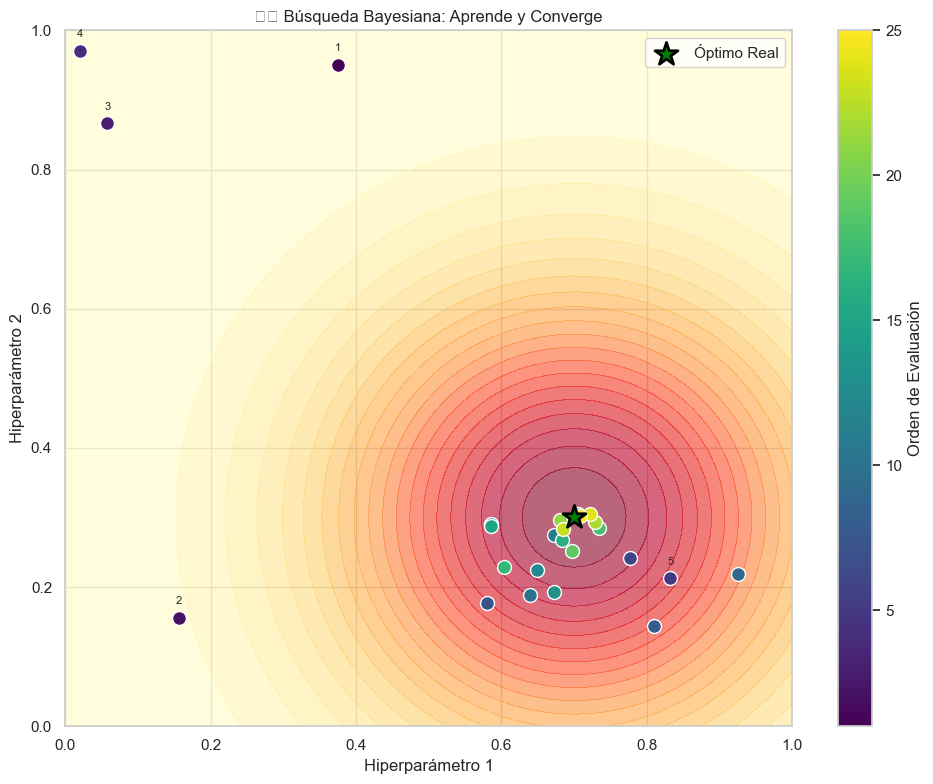

🕵️ Bayesiana mejor valor: 1.018
📍 Nota cómo los puntos se concentran cerca del óptimo.


In [6]:
# Simulación de búsqueda Bayesiana (simplificada)
def bayesian_search_simulation(n_trials=25):
    """Simula cómo la búsqueda Bayesiana se acerca al óptimo"""
    np.random.seed(42)

    # Historial de puntos
    points = []
    values = []

    # Fase 1: Exploración inicial (5 puntos aleatorios)
    for _ in range(5):
        x, y = np.random.uniform(0, 1, 2)
        points.append((x, y))
        values.append(funcion_objetivo(x, y))

    # Fase 2: Explotación informada
    for i in range(5, n_trials):
        # Encontrar el mejor punto hasta ahora
        best_idx = np.argmax(values)
        best_x, best_y = points[best_idx]

        # Explorar cerca del mejor (con algo de ruido para explorar)
        noise = 0.15 * (1 - i/n_trials)  # Reducir ruido con el tiempo
        new_x = np.clip(best_x + np.random.normal(0, noise), 0, 1)
        new_y = np.clip(best_y + np.random.normal(0, noise), 0, 1)

        points.append((new_x, new_y))
        values.append(funcion_objetivo(new_x, new_y))

    return points, values


bayes_points, bayes_values = bayesian_search_simulation(25)

# Visualización
fig, ax = plt.subplots(figsize=(10, 8))

ax.contourf(X, Y, Z, levels=20, cmap='YlOrRd', alpha=0.6)

# Colorear por orden de evaluación
colors = plt.cm.viridis(np.linspace(0, 1, len(bayes_points)))
for i, ((x, y), val) in enumerate(zip(bayes_points, bayes_values)):
    ax.scatter(x, y, c=[colors[i]], s=100, edgecolors='white', zorder=5)
    if i < 5:
        ax.annotate(f'{i+1}', (x, y), textcoords="offset points",
                    xytext=(0, 10), ha='center', fontsize=8)

ax.scatter(0.7, 0.3, c='green', s=300, marker='*', edgecolors='black',
           linewidth=2, zorder=10, label='Óptimo Real')

# Colorbar para indicar orden
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(1, 25))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Orden de Evaluación')

ax.set_xlabel('Hiperparámetro 1')
ax.set_ylabel('Hiperparámetro 2')
ax.set_title('🕵️ Búsqueda Bayesiana: Aprende y Converge')
ax.legend()
plt.tight_layout()
plt.show()

print(f"🕵️ Bayesiana mejor valor: {max(bayes_values):.3f}")
print(f"📍 Nota cómo los puntos se concentran cerca del óptimo.")


> **💡 Pro-Tip: La Magia de Optuna**
> Optuna implementa búsqueda Bayesiana con varios trucos adicionales:
> - **Pruning:** Mata entrenamientos malos a la mitad
> - **TPE (Tree-Parzen Estimator):** Modelo probabilístico eficiente
> - **Paralelización:** Puede correr múltiples trials a la vez
> 
> Es el estándar de la industria para optimización de hiperparámetros.

---

## 7. Comparativa Visual

### Todas las Estrategias Juntas

C:\Users\Theki\AppData\Local\Temp\ipykernel_34264\2986692393.py:24: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


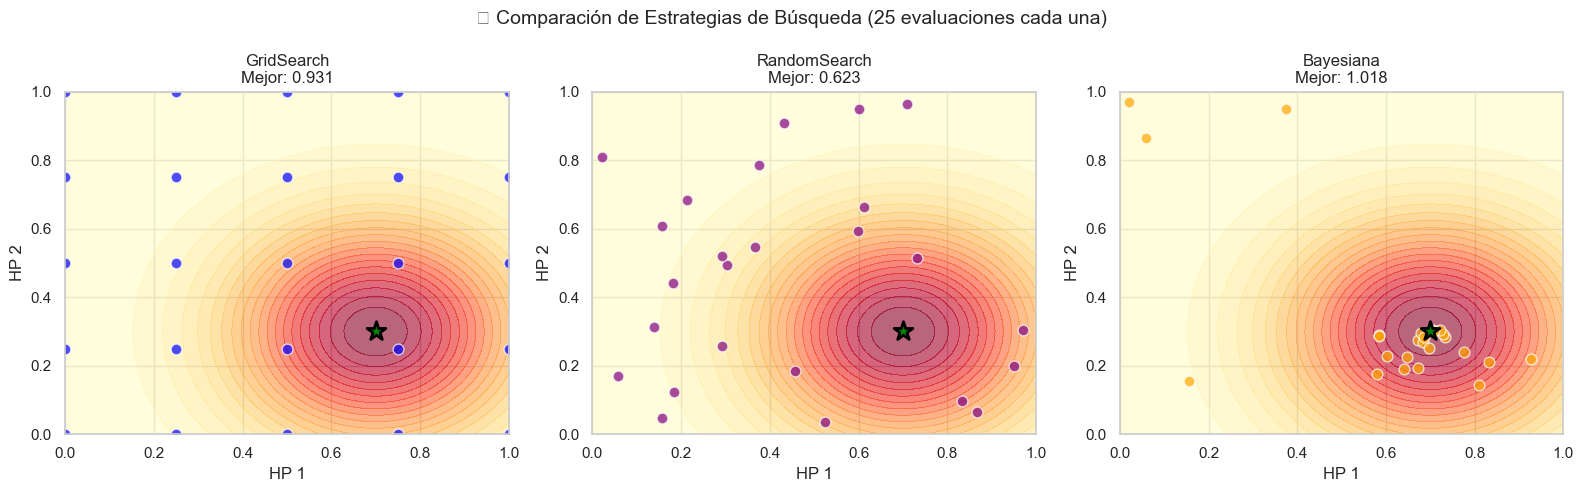

In [7]:
# Comparación final de las 3 estrategias
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

strategies = [
    ('GridSearch', grid_points, grid_values, 'blue'),
    ('RandomSearch', random_points, random_values, 'purple'),
    ('Bayesiana', bayes_points, bayes_values, 'orange')
]

for ax, (name, points, values, color) in zip(axes, strategies):
    ax.contourf(X, Y, Z, levels=20, cmap='YlOrRd', alpha=0.6)

    for (x, y) in points:
        ax.scatter(x, y, c=color, s=60, edgecolors='white', alpha=0.7)

    ax.scatter(0.7, 0.3, c='green', s=200, marker='*',
               edgecolors='black', linewidth=2)
    ax.set_title(f'{name}\nMejor: {max(values):.3f}')
    ax.set_xlabel('HP 1')
    ax.set_ylabel('HP 2')

plt.suptitle(
    '🏆 Comparación de Estrategias de Búsqueda (25 evaluaciones cada una)', fontsize=14)
plt.tight_layout()
plt.show()


In [8]:
# Tabla resumen
comparacion = pd.DataFrame({
    'Estrategia': ['GridSearch', 'RandomSearch', 'Bayesiana'],
    'Mejor Score': [max(grid_values), max(random_values), max(bayes_values)],
    'Evaluaciones': [25, 25, 25],
    'Complejidad': ['O(k^n)', 'O(t)', 'O(t)'],
    'Ventaja': ['Exhaustivo', 'Simple y paralelo', 'Más eficiente'],
    'Desventaja': ['Exponencial', 'No aprende', 'Más complejo de implementar']
})

print("📊 Tabla Comparativa")
print("=" * 80)
display(comparacion)


📊 Tabla Comparativa


,Estrategia,Mejor Score,Evaluaciones,Complejidad,Ventaja,Desventaja
0,GridSearch,0.930973,25,O(k^n),Exhaustivo,Exponencial
1,RandomSearch,0.623189,25,O(t),Simple y paralelo,No aprende
2,Bayesiana,1.018060,25,O(t),Más eficiente,Más complejo de implementar


### 🧠 Micro-Desafío: ¿Cuál Elegirías?

**Escenario 1:** Tienes solo 2 hiperparámetros y 3 valores cada uno. Tiempo ilimitado.
- ¿Qué estrategia usarías?

**Escenario 2:** Tienes 10 hiperparámetros y solo 50 evaluaciones disponibles.
- ¿Qué estrategia usarías?

**Escenario 3:** Tienes 5 hiperparámetros pero cada entrenamiento tarda 2 horas.
- ¿Qué estrategia usarías?

---

## 8. Resumen y Siguiente Paso

### 🏆 Resumen de Logros
¡Felicidades! En este notebook has aprendido:

1. **Parámetros vs Hiperparámetros:** Los primeros se aprenden, los segundos los defines tú.
2. **El Problema Combinatorio:** Con muchos HPs, GridSearch es impracticable.
3. **GridSearch:** Exhaustivo pero ineficiente. Solo para pocos HPs.
4. **RandomSearch:** Mejor cobertura, pero no aprende de intentos previos.
5. **Búsqueda Bayesiana:** Aprende del pasado, converge al óptimo más rápido.

### 📐 Regla de Oro

| Situación | Estrategia Recomendada |
|-----------|------------------------|
| ≤ 2 HPs, pocos valores | GridSearch |
| 3-5 HPs, tiempo limitado | RandomSearch |
| ≥ 5 HPs, maximizar eficiencia | **Optuna (Bayesiana)** |

---

### 👉 Siguiente Paso
Ahora que entiendes la teoría, es hora de **usar Optuna en un caso real**.

En el siguiente notebook (`01_Optimization_and_Money.ipynb`):
- Optimizaremos LightGBM con Optuna
- Veremos gráficos de optimización profesionales
- Conectaremos el tuning con métricas de negocio ($$)

*"No basta con encontrar el mejor modelo. Hay que encontrar el modelo que da más dinero."*